# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones

Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

## Definición de constantes, funciones *helper*, y lectura del conjunto de datos

Se trabajó sobre los *dataframes* `melb_suburb_df` y `melb_housing_df` que
fueron obtenidos en `normalize_melbourne_dataset.ipynb` alojados en un servidor
de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 7.8MB/s 
     |████████████████████████████████| 15.4MB 189kB/s 
     |████████████████████████████████| 6.6MB 34.8MB/s 


In [ ]:
from typing import Tuple, List, Optional
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import geopandas as gpd
import requests
import missingno as msno


def clean_outliers(df: pd.DataFrame,
                   column_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Filters out entries of @df that have in @column_name values which are 2.5
    times standard deviations apart from the mean. Returns both, entries that
    hold and miss the condition.
    """
    col = df[column_name]
    mask_outlier = np.abs(col - col.mean()) <= (2.5 * col.std())
    return df[mask_outlier], df[~mask_outlier]


def to_categorical(column: pd.Series, bin_size: int, min_cut: int,
                   max_cut: int) -> pd.Series:
    """
    Returns a pandas series where each value of @column is replaced by an
    interval that contains it. Intervals are generated from @min_cut to @max_cut
    and have size @bin_size.
    """
    if min_cut is None:
        min_cut = int(round(column.min())) - 1
    value_max = int(np.ceil(column.max()))
    max_cut = min(max_cut, value_max)
    intervals = [(x, x + bin_size) for x in range(min_cut, max_cut, bin_size)]
    if max_cut != value_max:
        intervals.append((max_cut, value_max))
    return pd.cut(column, pd.IntervalIndex.from_tuples(intervals))


def plot_melbourne_map(locations_df: gpd.GeoDataFrame,
                       key_regions: List[str],
                       column_name_colorbar: Optional[str] = None) -> None:
    """
    Plots a map of the surroundings of Melbourne, displaying the regions given by
    @key_regions. @location_df needs to be a geodataframe that contains the
    latitude and longitude as pandas points, so they can be superimposed on the
    background map. If @column_name_colorbar is provided, it needs to be the
    name of a column of @locations_df. Then, it colors the points and adds a
    colorbar indicating the magnitude of the values contained in that column.
    """
    geoserver = "https://data.gov.au/geoserver"
    route = "vic-state-electoral-boundaries-psma-administrative-boundaries"
    service = "wfs"
    projection = "EPSG:3110"
    wfsurl = f"{geoserver}/{route}/{service}"

    params = dict(service="WFS",
                  version="2.0.0",
                  request="GetFeature",
                  typeName=(route +
                            ":ckan_a0d8838b_2423_4c8b_a7d9_b04eb240a2b1"),
                  outputFormat="json")
    features = requests.get(wfsurl, params=params).json()
    region_location_df = gpd.GeoDataFrame.from_features(features).set_crs(
        projection)

    only_key_regions = region_location_df["vic_stat_2"].isin(key_regions)
    region_location_df = (
        region_location_df.loc[only_key_regions,
                               ["vic_stat_2", "geometry"]].dissolve(
                                   by="vic_stat_2").reset_index())
    background = region_location_df.plot(column="vic_stat_2",
                                         edgecolor="black",
                                         figsize=(15, 15),
                                         legend=True)
    plt.ylabel("Latitude")
    plt.xlabel("Longitude")
    background.set(title="Regiones del Territorio de Victoria, Australia")

    if column_name_colorbar is not None:
        cmap = seaborn.color_palette("flare", as_cmap=True)
        points = locations_df.plot(ax=background,
                                   marker="o",
                                   markersize=3,
                                   column=column_name_colorbar,
                                   cmap=cmap)

        fig = points.get_figure()
        cbax = fig.add_axes([0.95, 0.2, 0.04, 0.60])
        cbax.set_title(column_name_colorbar)
        sm = plt.cm.ScalarMappable(
            cmap=cmap,
            norm=plt.Normalize(vmin=min(locations_df[column_name_colorbar]),
                               vmax=max(locations_df[column_name_colorbar])))
        fig.colorbar(sm, cax=cbax, format="%d")
    else:
        points = locations_df.plot(ax=background,
                                   marker="o",
                                   markersize=3,
                                   color="r")

In [ ]:
URL_MELB_HOUSING_DATA = "https://www.famaf.unc.edu.ar/~nocampo043/melb_housing_df.csv"
URL_MELB_SUBURB_DATA = "https://www.famaf.unc.edu.ar/~nocampo043/melb_suburb_df.csv"

melb_housing_df = pd.read_csv(URL_MELB_HOUSING_DATA)
melb_suburb_df = pd.read_csv(URL_MELB_SUBURB_DATA)

In [ ]:
melb_suburb_df

,suburb_name,suburb_postcode,suburb_region_name,suburb_property_count,suburb_council_area,suburb_description_wordcount,suburb_neighborhoods_overview_wordcount,suburb_transit_wordcount,suburb_rental_dailyprice
0,Abbotsford,3067.0,Northern Metropolitan,4019.0,['Yarra'],"[('apartment', 194), ('city', 178), ('room', 1...","[('abbotsford', 181), ('walk', 151), ('street'...","[('tram', 176), ('walk', 148), ('street', 144)...",117.719512
1,Airport West,3042.0,Western Metropolitan,3464.0,['Moonee Valley'],"[('min', 30), ('airport', 26), ('walk', 25), (...","[('shops', 12), ('shopping', 12), ('quiet', 10...","[('tram', 22), ('take', 14), ('city', 14), ('b...",75.105263
2,Albert Park,3206.0,Southern Metropolitan,3280.0,['Port Phillip'],"[('park', 164), ('beach', 135), ('melbourne', ...","[('park', 170), ('melbourne', 107), ('albert',...","[('tram', 111), ('st', 67), ('melbourne', 64),...",227.011494
3,Alphington,3078.0,Northern Metropolitan,2211.0,"['Darebin', 'Yarra']","[('room', 89), ('house', 64), ('fairfield', 59...","[('fairfield', 57), ('walk', 35), ('cafes', 30...","[('station', 73), ('train', 65), ('bus', 49), ...",101.979592
4,Altona,3018.0,Western Metropolitan,5301.0,['Hobsons Bay'],"[('beach', 30), ('walk', 26), ('train', 24), (...","[('beach', 16), ('williamstown', 8), ('altona'...","[('train', 29), ('station', 25), ('airport', 1...",82.166667
...,...,...,...,...,...,...,...,...,...
309,Attwood,3049.0,Northern Metropolitan,1130.0,NaN,NaN,NaN,NaN,NaN
310,Wallan,3756.0,Northern Victoria,3988.0,NaN,NaN,NaN,NaN,NaN
311,New Gisborne,3438.0,Northern Victoria,849.0,NaN,NaN,NaN,NaN,NaN
312,Plumpton,3335.0,Western Metropolitan,1490.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
melb_housing_df

,housing_address,housing_room_count,housing_type,housing_price,housing_selling_method,housing_seller_agency,housing_date_sold,housing_cbd_distance,housing_bedroom_count,housing_bathroom_count,housing_garage_count,housing_land_size,housing_building_area,housing_year_built,housing_lattitude,housing_longitude,suburb_id
0,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,2.0,1.0,1.0,202.0,NaN,NaN,-37.79960,144.99840,0
1,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.80790,144.99340,0
2,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,-37.80930,144.99440,0
3,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3.0,2.0,1.0,94.0,NaN,NaN,-37.79690,144.99690,0
4,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,-37.80720,144.99410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,4.0,2.0,2.0,652.0,NaN,1981.0,-37.90562,145.16761,248
13576,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3.0,2.0,2.0,333.0,133.0,1995.0,-37.85927,144.87904,104
13577,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3.0,2.0,4.0,436.0,NaN,1997.0,-37.85274,144.88738,104
13578,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,4.0,1.0,5.0,866.0,157.0,1920.0,-37.85908,144.89299,104


## Elección de variables relevantes
Dado que el objetivo es predecir el precio de venta de viviendas en Melbourne se
procedió a analizar cuáles son las variables que influyen.

### Precio de venta (`housing_price`)

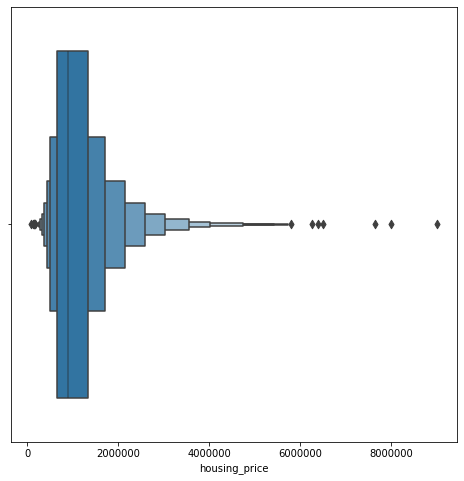

In [ ]:
plt.figure(figsize=(8, 8))
seaborn.boxenplot(data=melb_housing_df, x="housing_price")
plt.ticklabel_format(style="plain", axis="x")

Se observa la presencia de outliers en la variable `housing_price`, por encima
de los 6 millones. Se decidió eliminar aquellos valores atípicos que se
encuentran alejados de la media, más allá de 2.5 veces su desviación estandar.
TODO: Explicar cuál es la razón de que se descarten estos valores.

In [ ]:
melb_housing_df, melb_housing_outliers_df = clean_outliers(
    melb_housing_df, "housing_price")

In [ ]:
melb_housing_df

,housing_address,housing_room_count,housing_type,housing_price,housing_selling_method,housing_seller_agency,housing_date_sold,housing_cbd_distance,housing_bedroom_count,housing_bathroom_count,housing_garage_count,housing_land_size,housing_building_area,housing_year_built,housing_lattitude,housing_longitude,suburb_id
0,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,2.0,1.0,1.0,202.0,NaN,NaN,-37.79960,144.99840,0
1,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,2.0,1.0,0.0,156.0,79.0,1900.0,-37.80790,144.99340,0
2,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3.0,2.0,0.0,134.0,150.0,1900.0,-37.80930,144.99440,0
3,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3.0,2.0,1.0,94.0,NaN,NaN,-37.79690,144.99690,0
4,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3.0,1.0,2.0,120.0,142.0,2014.0,-37.80720,144.99410,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,4.0,2.0,2.0,652.0,NaN,1981.0,-37.90562,145.16761,248
13576,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3.0,2.0,2.0,333.0,133.0,1995.0,-37.85927,144.87904,104
13577,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3.0,2.0,4.0,436.0,NaN,1997.0,-37.85274,144.88738,104
13578,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,4.0,1.0,5.0,866.0,157.0,1920.0,-37.85908,144.89299,104


In [ ]:
melb_housing_outliers_df

,housing_address,housing_room_count,housing_type,housing_price,housing_selling_method,housing_seller_agency,housing_date_sold,housing_cbd_distance,housing_bedroom_count,housing_bathroom_count,housing_garage_count,housing_land_size,housing_building_area,housing_year_built,housing_lattitude,housing_longitude,suburb_id
80,112 Beaconsfield Pde,3,h,2850000.0,PI,Buxton,4/03/2017,3.3,3.0,2.0,0.0,211.0,198.0,1890.0,-37.84810,144.94990,2
102,97 Page St,3,h,3010000.0,S,Greg,18/03/2017,3.3,3.0,2.0,0.0,147.0,146.0,1890.0,-37.84730,144.95510,2
103,55 Withers St,4,h,2800000.0,VB,Cayzer,18/06/2016,3.3,4.0,3.0,1.0,327.0,254.0,1910.0,-37.84670,144.94750,2
108,115 Page St,4,h,4735000.0,S,Marshall,25/02/2017,3.3,4.0,2.0,1.0,330.0,207.0,1910.0,-37.84770,144.95580,2
112,22 Greig St,3,h,3755000.0,S,Greg,26/07/2016,3.3,3.0,2.0,2.0,325.0,NaN,NaN,-37.84130,144.95000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13468,16 Hodgson St,5,h,3450000.0,PI,Kay,26/08/2017,5.4,5.0,2.0,2.0,668.0,0.0,2006.0,-37.80795,145.01474,61
13474,707 Toorak Rd,4,h,3080000.0,SP,Jellis,26/08/2017,5.9,4.0,2.0,3.0,620.0,339.0,1930.0,-37.84391,145.03376,63
13483,88 The Esplanade,3,h,3400000.0,SP,Jas,26/08/2017,4.3,3.0,1.0,5.0,2027.0,187.0,1964.0,-37.76570,144.89109,67
13553,20 Albert Cr,4,h,2720000.0,S,Kay,26/08/2017,10.2,4.0,3.0,2.0,1005.0,NaN,1920.0,-37.82421,145.10352,97


A continuación, se analizaron las demás variables sin los *outliers* del precio
de venta.

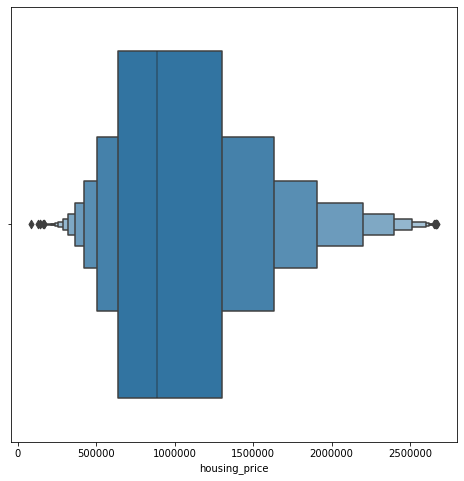

In [ ]:
plt.figure(figsize=(8,8))
seaborn.boxenplot(data=melb_housing_df, x="housing_price")
plt.ticklabel_format(style="plain", axis="x")

### Dirección de las viviendas (`housing_address`)
Si bien `housing_address` permite conocer la ubicación exacta de una propiedad,
no brinda información sobre aspectos de calidad que motiven la variación del
precio de una vivienda en Melbourne. Es un dato único que primero debería ser
agrupado en zonas para argumentar algún análisis. Agrupamiento que ya es
brindado en el conjunto de datos por medio de otras variables como el nombre del
suburbio, departamento, o el código postal.

In [ ]:
melb_housing_df["housing_address"].value_counts()

1/1 Clarendon St    3
5 Margaret St       3
5 Charles St        3
36 Aberfeldie St    3
13 Robinson St      3
                   ..
2/5 Parkhill Dr     1
136 Clark St        1
73 Park St          1
31 Orchard St       1
34 Lincoln Rd       1
Name: housing_address, Length: 13014, dtype: int64

### Cantidad habitaciones (`housing_bedroom_count`)
Dado que las variables `housing_bedroom_count`, `housing_room_count` están
fuertemente correlacionadas se optó por conservar la última de estas porque
`housing_bedroom_count` proveniene de otro *dataset*.

In [ ]:
melb_housing_df[
    ["housing_bedroom_count", "housing_room_count"]
].corr()

,housing_bedroom_count,housing_room_count
housing_bedroom_count,1.000000,0.942469
housing_room_count,0.942469,1.000000


### Cantidad de ambientes (`housing_room_count`)

In [ ]:
melb_housing_df[["housing_room_count"]].value_counts()

housing_room_count
3                     5816
2                     3638
4                     2505
1                      681
5                      492
6                       60
7                        8
8                        7
10                       1
dtype: int64

Se puede observar que la cantidad de ambientes varían entre 1 a 4, siendo
valores menos frecuentes aquellas que tienen 5 o más. Por ende, se decide
agrupar esta categoría.

In [ ]:
# Explicitly create a copy after adding the column to avoid chained indexes
melb_housing_df = melb_housing_df.assign(housing_room_segment=to_categorical(
    melb_housing_df["housing_room_count"], bin_size=1, min_cut=None,
    max_cut=4))

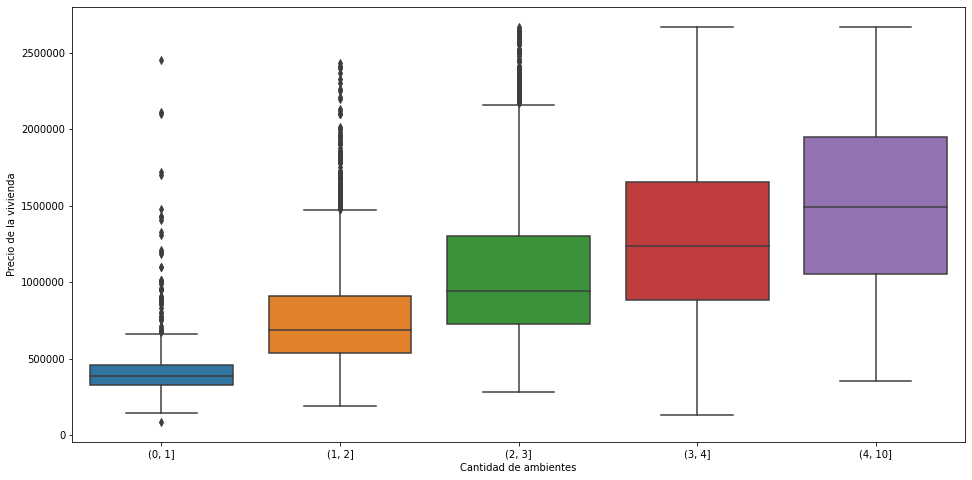

In [ ]:
plt.figure(figsize=(16, 8))
seaborn.boxplot(x="housing_room_segment",
                y="housing_price",
                data=melb_housing_df)
plt.ylabel("Precio de la vivienda")
plt.xlabel("Cantidad de ambientes")
plt.ticklabel_format(style='plain', axis='y')

Luego del análisis individual de la cantidad de ambientes, se puede observar que
existe un aumento de la mediana del precio de venta y su variabilidad.

### Cantidad de baños (`housing_bathroom`)

La cantidad de baños de las viviendas vendidas se encuentran en su mayoría entre
1 y 3 siendo valores más atípicos las que superan este rango. Por otro lado, se
encuentran propiedades con una cantidad de 0 baños lo cual resulta peculiar
recordando que los tipos de hogares en venta son casas, dúplex, y casas
adosadas.

In [ ]:
melb_housing_df[["housing_bathroom_count"]].value_counts()

housing_bathroom_count
1.0                       7480
2.0                       4826
3.0                        790
4.0                         57
0.0                         34
5.0                         16
6.0                          3
8.0                          2
dtype: int64

A continuación, se procedió a reemplazar estos valores por el más frecuente dado
que se considera que no puede haber una propiedad sin baño.

In [ ]:
min_bathroom_count = 1
lt_one_bathroom = melb_housing_df["housing_bathroom_count"] < min_bathroom_count
melb_housing_df.loc[lt_one_bathroom, "housing_bathroom_count"] = 1

Ahora bien, para aquellas viviendas que presenten entre 3 a más baños se
agruparán en una sola categoría con el fin de asegurar que los grupos 1, 2, y 3
o más baños, presenten una cantidad mínima de registros.

In [ ]:
melb_housing_df = melb_housing_df.assign(
    housing_bathroom_segment=to_categorical(
        melb_housing_df["housing_bathroom_count"],
        bin_size=1,
        min_cut=None,
        max_cut=2))

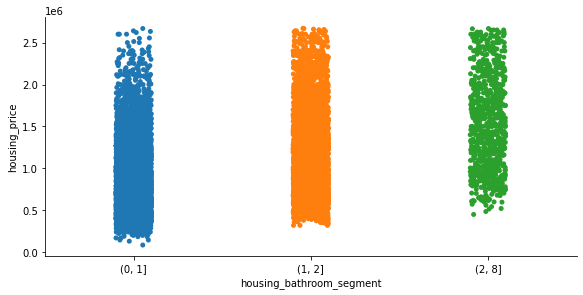

In [ ]:
seaborn.catplot(data=melb_housing_df,
                y="housing_price",
                x="housing_bathroom_segment",
                height=4,
                aspect=2)

Se puede observar una disminución en el rango de precios medida que aumenta la
cantidad de baños. Si bien el precio máximo es similar, el mínimo aumenta para
cada categoría.

### Cantidad de garages (`housing_garage_count`)

In [ ]:
melb_housing_df["housing_garage_count"].value_counts()

1.0     5468
2.0     5390
0.0     1013
3.0      696
4.0      454
5.0       59
6.0       49
8.0        7
7.0        6
10.0       3
9.0        1
Name: housing_garage_count, dtype: int64

In [ ]:
melb_housing_df = melb_housing_df.assign(housing_garage_segment=to_categorical(
    melb_housing_df["housing_garage_count"],
    bin_size=1,
    min_cut=None,
    max_cut=2))

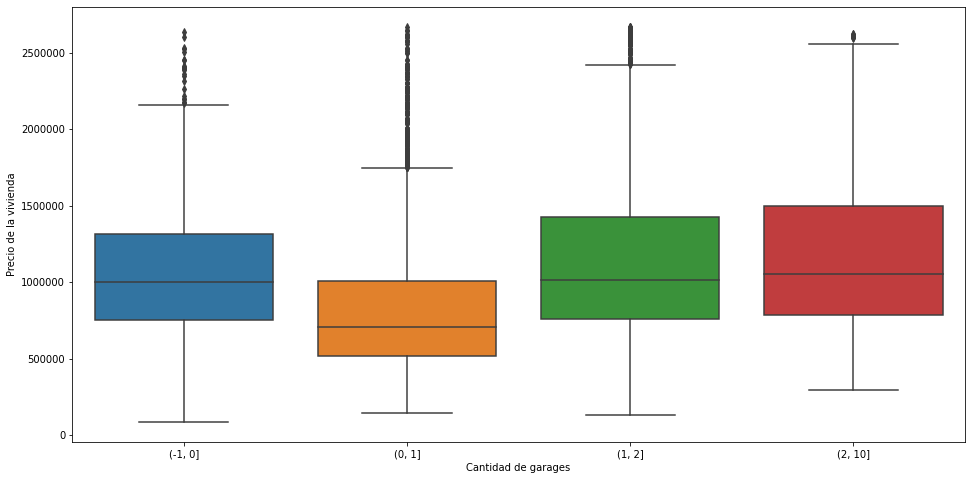

In [ ]:
plt.figure(figsize=(16, 8))
seaborn.boxplot(x="housing_garage_segment",
                y="housing_price",
                data=melb_housing_df)
plt.ylabel("Precio de la vivienda")
plt.xlabel("Cantidad de garages")
plt.ticklabel_format(style='plain', axis='y')

A excepción de las viviendas con un garage, el resto de categorías pareciera que
se comportan de manera similar ante la variable precio, por lo tanto se decidió
no seleccionar `housing_garage_count`. TODO: Verlo con Aldana. ¿Decidir sacarla?
¿Como tomar la decisión de descartarlo?

### Tamaño de terreno (`housing_land_size`)

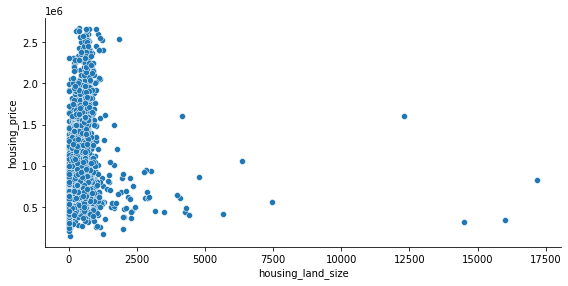

In [ ]:
seaborn.pairplot(data=melb_housing_df.sample(2500),
                 y_vars="housing_price",
                 x_vars="housing_land_size",
                 aspect=2,
                 height=4)

TODO: Verlo con Aldana. ¿Decidir sacarla? ¿Como tomar la decisión de
descartarlo?

## Área de construcción (`housing_building_area`)
Se considera que esta variable es importante para predecir el precio, por ende
se procedió a imputar sus valores faltantes en una sección posterior.

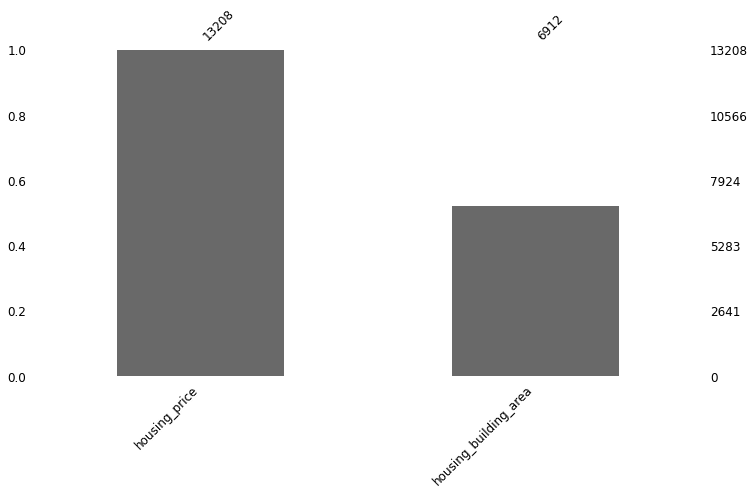

In [ ]:
msno.bar(melb_housing_df[["housing_price", "housing_building_area"]],
         figsize=(12, 6),
         fontsize=12)

### Tipo de vivienda (`housing_type`)
Significado de cada categoría:

- `h`: Casa.

- `u`: Unidad, dúplex.

- `t`: Casa adosada.

In [ ]:
(
    melb_housing_df[["housing_type", "housing_price"]]
        .groupby("housing_type")
        .describe()
        .round(2)
)

housing_price              ...                      
                     count        mean  ...        75%        max
housing_type                            ...                      
h                   9083.0  1155408.78  ...  1430000.0  2670000.0
t                   1109.0   924328.99  ...  1100000.0  2650000.0
u                   3016.0   604126.20  ...   706000.0  2460000.0

[3 rows x 8 columns]

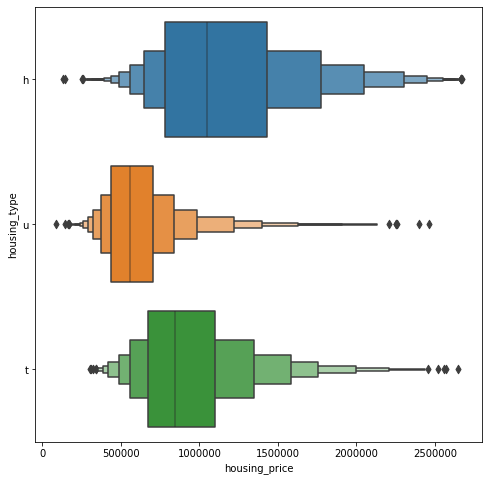

In [ ]:
plt.figure(figsize=(8,8))
seaborn.boxenplot(data=melb_housing_df, x="housing_price", y="housing_type")
plt.ticklabel_format(style="plain", axis="x")

Se observa que la variable tipo de vivienda, tiene influencia en el precio de la
propiedad.

- Para el tipo `h`, es decir casa, el precio medio se encuentra en valores
  cercanos a 1,2 millones. Estando el rango intercuartil comprendido entre los
  780 mil y 1,4 millones. Se observa que los valores máximos son superiores a
  los 2,5 millones.

- Para el caso de `u`, es decir duplex, el precio medio se encuentra en valores
  cercanos a los 600 mil. Estando el rango intercuartil comprendido entre los
  400 mil y 700 mil. Se observa que los valores máximos son superiores a los 2,5
  millones.

- Para el caso de `t`, es decir casa adosada, el precio medio se encuentra en
  valores un poco superiores a los 900 mil. Estando el rango intercuartil
  comprendido entre los 670 mil y 1,1 millones. Se observa que los valores
  máximos llegan también a casi 2,5 millones.

Visualizando los valores extremos del precio en función de esta variable se
obtiene. TODO: Cuando eliminar outliers? que análisis se hacen para quitarlos?

In [ ]:
(
    melb_housing_outliers_df[["housing_type", "housing_price"]]
        .groupby("housing_type")
        .describe()
        .round(2)
)

housing_price              ...                      
                     count        mean  ...        75%        max
housing_type                            ...                      
h                    366.0  3408091.22  ...  3682500.0  9000000.0
t                      5.0  3020000.00  ...  3275000.0  3475000.0
u                      1.0  3625000.00  ...  3625000.0  3625000.0

[3 rows x 8 columns]

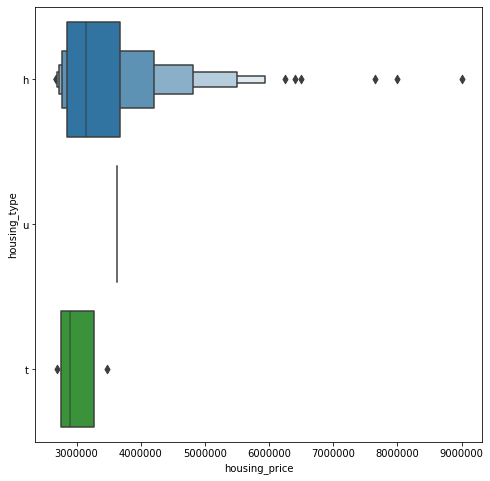

In [ ]:
plt.figure(figsize=(8,8))
seaborn.boxenplot(data=melb_housing_outliers_df,
                  x="housing_price",
                  y="housing_type")
plt.ticklabel_format(style="plain", axis="x")

Se observa que dentro de los outliers se están eliminando en mayor cantidad
casas con precios comprendidos entre los 3 millones y los 9 millones.

### Método de venta (`housing_selling_method`)
Significado de cada método:
- `PI` - Propiedad transferida.
- `S`  - Propiedad vendida.
- `SA` - Vendido después de subasta.
- `SP` - Propiedad vendida antes.
- `VB` - Oferta del proveedor.

In [ ]:
(
    melb_housing_df[["housing_selling_method", "housing_price"]]
        .groupby("housing_selling_method")
        .describe()
        .round(2)
)

housing_price              ...                      
                               count        mean  ...        75%        max
housing_selling_method                            ...                      
PI                            1510.0  1048281.13  ...  1400000.0  2650000.0
S                             8788.0  1026166.95  ...  1300000.0  2670000.0
SA                              90.0   982455.56  ...  1253750.0  2290000.0
SP                            1681.0   868442.47  ...  1078000.0  2655000.0
VB                            1139.0  1047033.36  ...  1450000.0  2650000.0

[5 rows x 8 columns]

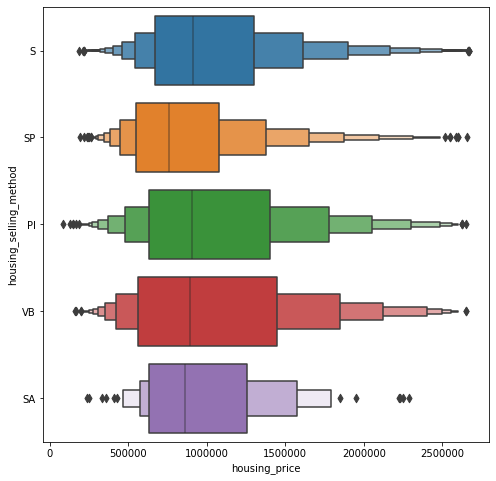

In [ ]:
plt.figure(figsize=(8,8))
seaborn.boxenplot(data=melb_housing_df,
                  x="housing_price",
                  y="housing_selling_method")
plt.ticklabel_format(style="plain", axis="x")

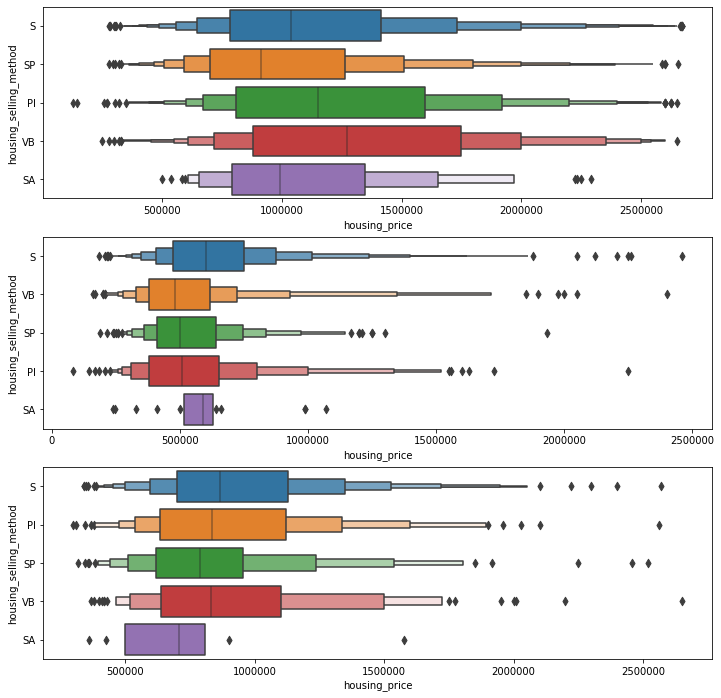

In [ ]:
types = melb_housing_df["housing_type"].unique()
fig, axes = plt.subplots(3, figsize=(12,12))

for ax, type in zip(axes, types):
    houses_by_type_df = melb_housing_df[
        melb_housing_df["housing_type"] == type
    ]
    seaborn.boxenplot(ax=ax,
                      data=houses_by_type_df,
                      x="housing_price",
                      y="housing_selling_method")
    ax.ticklabel_format(style="plain", axis="x")

Se observa que la distribución de la variable `housing_price` es similar en cada
método de venta. Los valores medios están cercanos al millón extendiéndose hasta
valores máximos cercanos a los 2,5 millones. El método de venta `SA`,
correspondiente a “vendido después de la subasta”, parece ser el más diferente.
No obstante, se observa que son pocos los casos comprendidos en esta categoría
(menos de 100), por lo cual la baja frecuencia podría justificar su disparidad
con el resto.

Consideramos no seleccionar el método venta para un siguiente análisis.

### Agencia de ventas (`housing_seller_agency`)

In [ ]:
melb_housing_df["housing_seller_agency"].value_counts()

Nelson           1554
Jellis           1240
hockingstuart    1152
Barry            1011
Ray               699
                 ... 
Upper               1
Calder              1
Property            1
Metro               1
SN                  1
Name: housing_seller_agency, Length: 266, dtype: int64

Existen 266 vendedores que efectúan las transacciones de las viviendas. A
continuación, se calcula si existe concentración de movimientos en alguno de
ellos.

In [ ]:
best_sellers_df = (
    melb_housing_df[["housing_seller_agency", "housing_price"]]
        .groupby("housing_seller_agency")
        .agg(sales_count=("housing_seller_agency", "count"),
             sales_percentage=("housing_seller_agency",
                                lambda sales: 100 * len(sales) / len(melb_housing_df)))
        .sort_values(by="sales_count", ascending=False)
        .head(20)
)

In [ ]:
best_sellers_df.sum()

sales_count         9939.000000
sales_percentage      75.249849
dtype: float64

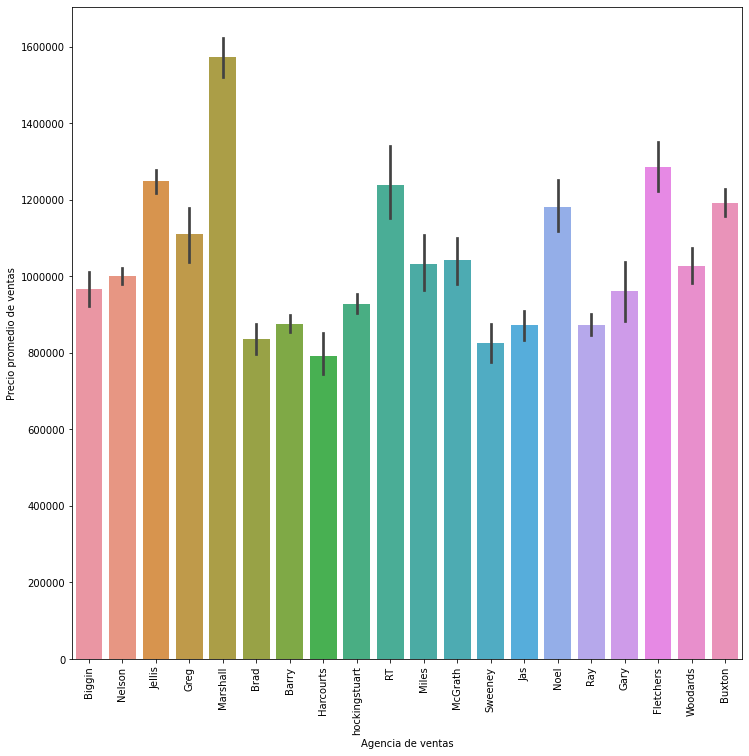

In [ ]:
fig = plt.figure(figsize=(12, 12))
seaborn.barplot(
    data=melb_housing_df[melb_housing_df["housing_seller_agency"].isin(
        best_sellers_df.index)],
    x="housing_seller_agency",
    y="housing_price",
    estimator=np.mean)
plt.xlabel("Agencia de ventas")
plt.ylabel("Precio promedio de ventas")
plt.xticks(rotation=90)
plt.ticklabel_format(style="plain", axis="y")

Se puede observar que algunos vendedores en promedio han vendido casas a precios
más altos que otros, por ejemplo el vendedor `Marshall` sobresale por el resto
con un precio medio de venta de 1,5 millones. Sin embargo, no se puede asegurar
que el mayor precio de la venta sea por una mejor gestión del vendedor y no por
otro tipo de variable, como ser el tipo de casa, la ubicación o bien su tamaño o
composición. Por lo tanto tampoco se decidió seleccionarla.

### Región y distancia al distrito central comercial (`housing_region_name`, y `housing_cbd_distance`)
Para analizar las medidas de tendencia central del precio de las viviendas por
región se realizó un boxplot como se muestra a continuación.

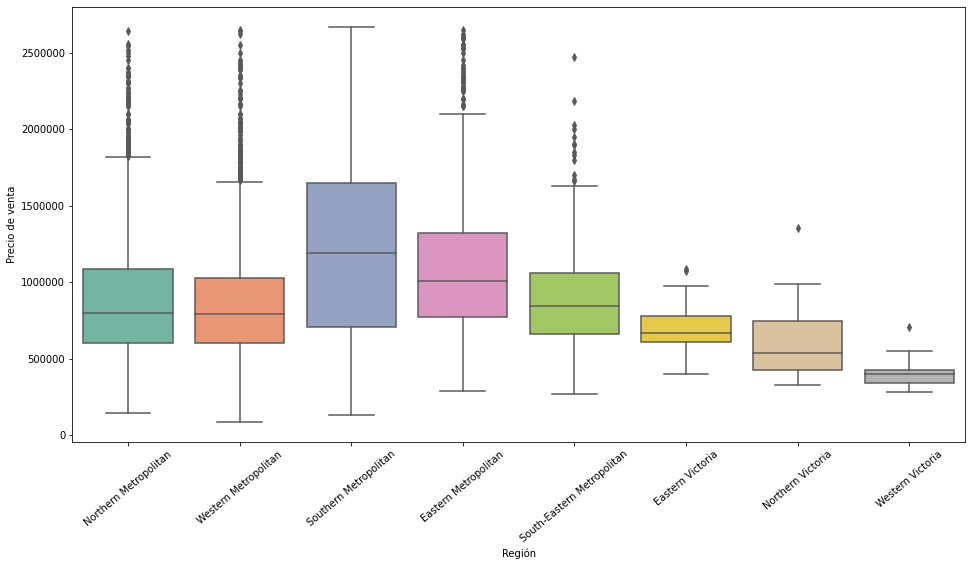

In [ ]:
plt.figure(figsize=(16, 8))
seaborn.boxplot(x="suburb_region_name",
                y="housing_price",
                palette="Set2",
                data=melb_housing_df.join(melb_suburb_df, on="suburb_id"))
plt.xticks(rotation=40)
plt.ylabel("Precio de venta")
plt.xlabel("Región")
plt.ticklabel_format(style="plain", axis="y")

`Southern Metropolitan` es la región con la media más alta en el precio de
viviendas. `Northern Metropolitan`, `Western Motropolitan`, y `South-Eastern
Metropolitan` parecieran seguir un comportamiento similar. De la misma manera
ocurre con `Eastern Victoria`, `Northern Victoria`, y `Western Victoria`.

La siguiente tabla muestra que `Southern Metropolitan` es la región en donde se
registró una mayor cantidad de ventas de viviendas (4377) a diferencia de
`Eastern Victoria`, `Northern Victoria` y `Western Victoria` que muestran menos
de
100.

In [ ]:
(
    melb_housing_df
        .join(melb_suburb_df, on="suburb_id")
        .loc[:, "suburb_region_name"]
        .value_counts()
)

Southern Metropolitan         4377
Northern Metropolitan         3860
Western Metropolitan          2939
Eastern Metropolitan          1458
South-Eastern Metropolitan     448
Eastern Victoria                53
Northern Victoria               41
Western Victoria                32
Name: suburb_region_name, dtype: int64

## Geolocalización de propiedades por región
El objetivo es ver la geolocalización de los datos en las diferentes regiones
del Territorio de Victoria, Australia. A continuación, se muestra una imagen
extraída de Wikipedia.

<img src="https://github.com/benjaminocampo/DataCuration/blob/master/notebooks/graphs/melbourne_by_region.png?raw=1" alt="melbourne by region">

Se utilizó el servicio de [wfs de geoserver](https://data.gov.au/geoserver)
donde se obtiene una representación geométrica de las regiones.

In [ ]:
geoserver = "https://data.gov.au/geoserver"
route = "vic-state-electoral-boundaries-psma-administrative-boundaries"
service = "wfs"
projection = "EPSG:3110"

wfsurl = f"{geoserver}/{route}/{service}"

params = dict(service="WFS",
              version="2.0.0",
              request="GetFeature",
              typeName=(route + ":ckan_a0d8838b_2423_4c8b_a7d9_b04eb240a2b1"),
              outputFormat="json")

features = requests.get(wfsurl, params=params).json()

region_location_df = gpd.GeoDataFrame.from_features(features).set_crs(
    projection)

region_location_df.head()

,geometry,se_ply_pid,dt_create,dt_retire,se_pid,vic_state_,vic_stat_1,vic_stat_2,vic_stat_3,vic_stat_4,vic_stat_5,vic_stat_6,vic_stat_7
0,"MULTIPOLYGON (((145.34291 -38.50482, 145.34253...",1112,2015-05-05Z,None,VIC221,2015-05-05Z,None,BASS,None,None,2014-11-28Z,2,2
1,"MULTIPOLYGON (((145.34186 -38.50041, 145.34248...",1113,2015-05-05Z,None,VIC195,2015-05-05Z,None,EASTERN VICTORIA,None,None,2014-11-28Z,2,3
2,"MULTIPOLYGON (((145.34607 -38.50860, 145.34597...",1114,2015-05-05Z,None,VIC196,2015-05-05Z,None,EASTERN VICTORIA,2013-10-17Z,2014-11-29Z,None,2,3
3,"MULTIPOLYGON (((145.34607 -38.50860, 145.34597...",1115,2015-05-05Z,None,VIC220,2015-05-05Z,None,BASS,2013-10-17Z,2014-11-29Z,None,2,2
4,"MULTIPOLYGON (((145.30997 -38.23814, 145.30983...",1116,2015-05-05Z,None,VIC195,2015-05-05Z,None,EASTERN VICTORIA,None,None,2014-11-28Z,2,3


De este *dataframe* se obtiene información correspondiente a las divisiones
gubernamentales de Melbourne. En particular, la columna `vic_stat_2` es aquella
que contiene los nombres de regiones, y `geometry` su representación geométrica
limítrofe. La proyección sobre las zonas de Melbourne es dada por el método
`set_crs` que establece coordenadas arbitrarias del espacio en una ubicación
particular del planeta. Sin embargo, hay varias zonas que se muestran en los
alrededores de Melbourne, por ende, se filtran por aquellas que correspondan a
las que se tiene registro en el conjunto de datos inicial.

In [ ]:
key_regions = [
    region.upper() for region in melb_suburb_df["suburb_region_name"].unique()
]

De manera similar, se necesita convertir las coordenadas de las propiedades
vendidas en puntos geométricos de GeoPandas para ser graficados junto a las
zonas recolectadas. En particular, en este caso serán representados como un
objeto `POINT`. El *dataframe* subyacente es el siguiente:

In [ ]:
locations_df = gpd.GeoDataFrame(
    melb_housing_df[["housing_lattitude", "housing_longitude"]],
    geometry=gpd.points_from_xy(
        melb_housing_df["housing_longitude"],
        melb_housing_df["housing_lattitude"])).set_crs("EPSG:3110")

locations_df.head()

,housing_lattitude,housing_longitude,geometry
0,-37.7996,144.9984,POINT (144.99840 -37.79960)
1,-37.8079,144.9934,POINT (144.99340 -37.80790)
2,-37.8093,144.9944,POINT (144.99440 -37.80930)
3,-37.7969,144.9969,POINT (144.99690 -37.79690)
4,-37.8072,144.9941,POINT (144.99410 -37.80720)


Finalmente, se procede a graficar las zonas limítrofes de Melbourne
superponiendo las ubicaciones de las viviendas. El mapa muestra que la mayoría
de las ventas (en color rojo) se concentran en la región Metropolitana
(`South-Eastern Metropolitan`, `Southern Metropolitan`, `Western Metropolitan` y
`Northern Metropolitan`).

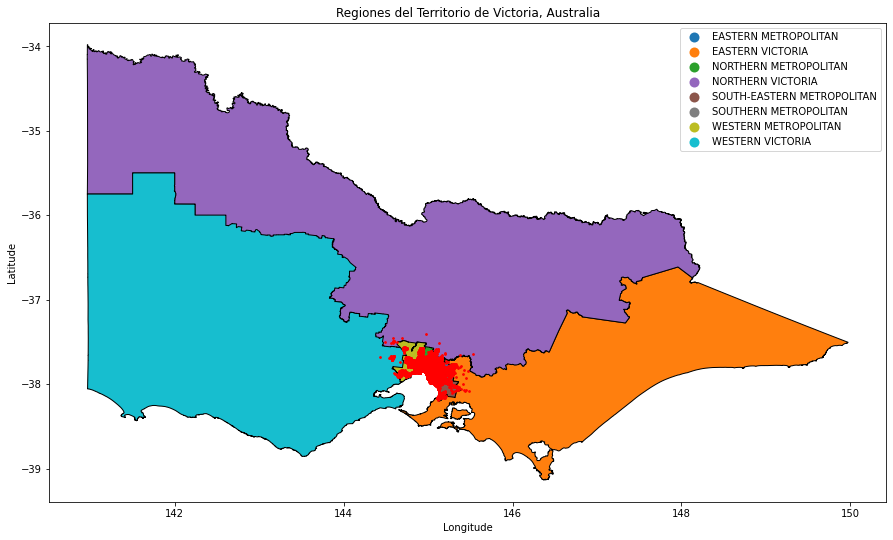

In [ ]:
plot_melbourne_map(locations_df, key_regions)

Para observar con mayor detalle la zona metropolitana, se filtran las entradas
de `region_location_df` y se incluye en el mapa la variable
`housing_cbd_distance` que indica la distancia que una propiedad tiene al
distrito central comercial. Se muestra que las viviendas más cerca al centro
(valores de distancia cercanos a cero de color naranja claro), se encuentran en
`Southern Metropolitan` donde también se encuentra la ciudad de Melbourne.

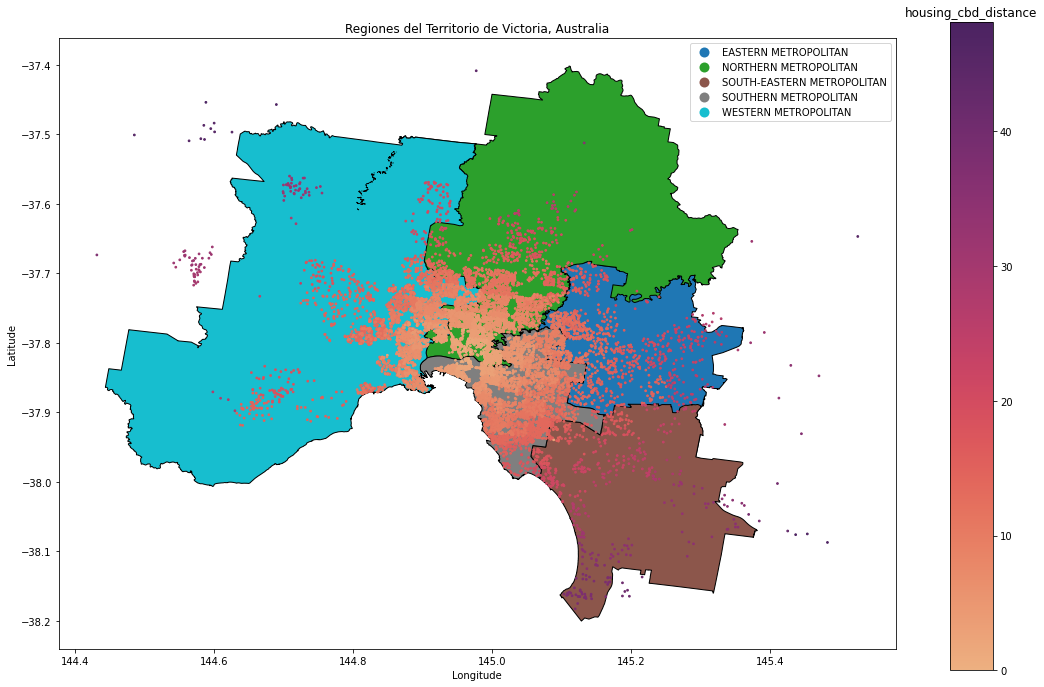

In [ ]:
metropolitan_regions = [
    region_name for region_name in key_regions
    if region_name.endswith("METROPOLITAN")
]

plot_melbourne_map(locations_df.join(melb_housing_df["housing_cbd_distance"]),
                   metropolitan_regions, "housing_cbd_distance")

También, se realizó otro mapa incluyendo a la variable `housing_price`, el cual
muestra que los precios de vivienda más altos se localizan en las regiones de
`Southern Metropolitan` y `Estearn Metropolitan`. TODO: Se repite el código del
gráfico. Capaz se podría hacer una función.

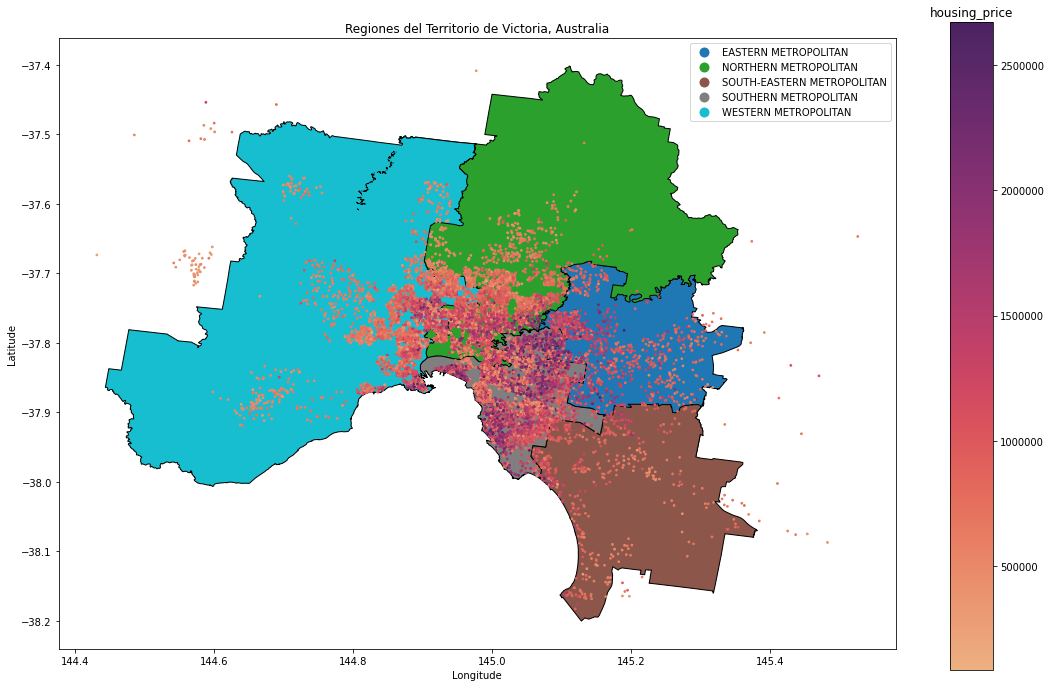

In [ ]:
plot_melbourne_map(locations_df.join(melb_housing_df["housing_price"]),
                   metropolitan_regions, "housing_price")

Estas observaciones dejan en evidencia que la localización de las viviendas
puede influir en el precio de las mismas. En este sentido, se decide incluir la
variable `suburb_region_name` en futuros análisis. Respecto a la variable
`housing_cbd_distance`, su mapa correspondiente muestra que los valores cercanos
al centro se ubican en la región `Southern Metropolitan` y aumenta a medida que
se aleja del mismo y cambia de región. Por lo tanto, a partir de conocer la
región en la que se ubica una vivienda se puede inferir su valor de distancia y
por ende `housing_cbd_distance` ofrecería información redundante. Entonces se
decidió no incluirla en futuros análisis.

Se puede ver que las regiones `Western Victoria`, `Eastern Victoria`, y
`Northern Victoria` poseen una baja frecuencia. Por lo tanto, se procedió a
agruparlos bajo una misma categoría, denominada `Victoria`.

In [ ]:
(
    melb_housing_df
        .join(melb_suburb_df["suburb_region_name"], on="suburb_id")
        .groupby("suburb_region_name")
        .size()
)

suburb_region_name
Eastern Metropolitan          1458
Eastern Victoria                53
Northern Metropolitan         3860
Northern Victoria               41
South-Eastern Metropolitan     448
Southern Metropolitan         4377
Western Metropolitan          2939
Western Victoria                32
dtype: int64

In [ ]:
melb_suburb_df = melb_suburb_df.assign(
    suburb_region_segment=melb_suburb_df["suburb_region_name"].replace(
        {
            "Western Victoria": "Victoria",
            "Eastern Victoria": "Victoria",
            "Northern Victoria": "Victoria"
        }))

In [ ]:
(
    melb_housing_df
        .join(melb_suburb_df["suburb_region_segment"], on="suburb_id")
        .groupby("suburb_region_segment")
        .size()
)

suburb_region_segment
Eastern Metropolitan          1458
Northern Metropolitan         3860
South-Eastern Metropolitan     448
Southern Metropolitan         4377
Victoria                       126
Western Metropolitan          2939
dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

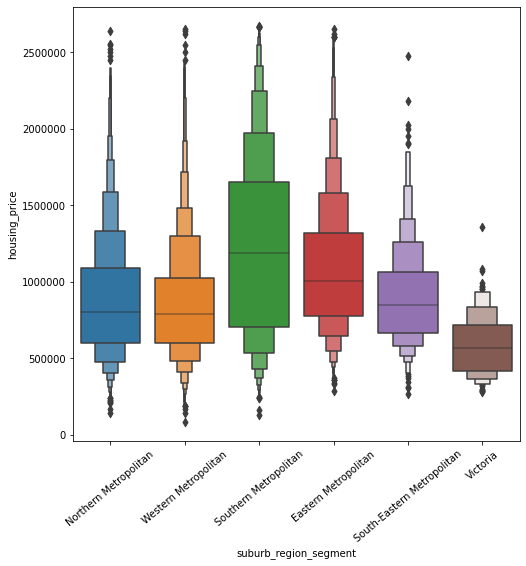

In [ ]:
plt.figure(figsize=(8, 8))
seaborn.boxenplot(data=melb_housing_df.join(
    melb_suburb_df["suburb_region_segment"], on="suburb_id"),
                  x="suburb_region_segment",
                  y="housing_price")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=40)

## Cantidad de propiedades por suburbio (`suburb_property_count`)

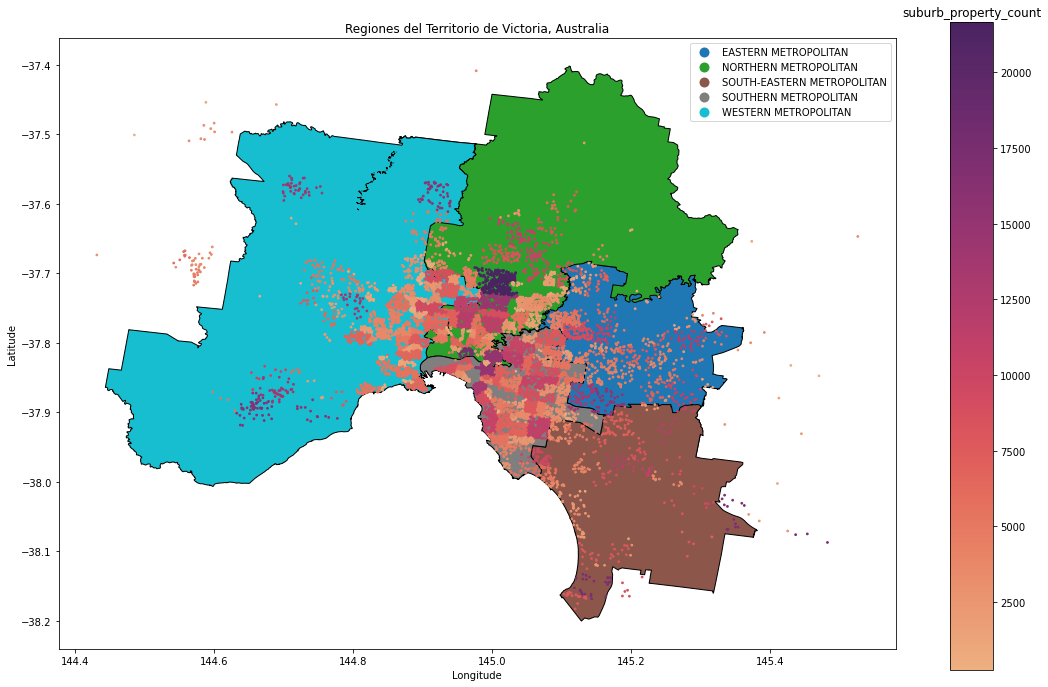

In [ ]:
plot_melbourne_map(
    (
        locations_df
            .join(melb_housing_df["suburb_id"])
            .join(melb_suburb_df["suburb_property_count"], on="suburb_id")
    ),
    metropolitan_regions, "suburb_property_count")

Se puede visualizar en los mapas anteriormente expuestos, que los suburbios que tienen mayor cantidad de propiedades, no necesariamente son los que mayores  precios de venta tienen. Por ejemplo, en la región `SOUTHERN METROPOLITAN` se encuentran los precios más altos (color violeta más oscuro), sin embargo en esa región suburb_property_count presenta una mayor variabilidad. 

## Departamento gubernamental (`housing_council_area`)
Analizando las medidas de tendencia central para las variables
`suburb_council_area` y `housing_price` se observa que algunos departamentos
tienen una única vivienda con precio y otros como `Boroondara` tiene más de 1000
viviendas. Esto muestra la disparidad en la cantidad de ventas registradas en
los diferentes departamentos. Dado que está variable brinda información similar
a otras ya disponibles en el *dataset* no se la consideró relevante para estimar
el precio, sin embargo, se la seleccionó para continuar con el resto de las
consignas del entregable.

In [ ]:
(
    melb_housing_df
        .join(melb_suburb_df, on="suburb_id")
        .loc[:, "suburb_council_area"]
        .value_counts()
)

['Moreland']                            1089
['Boroondara']                           924
['Moonee Valley']                        890
['Glen Eira']                            889
['Maribyrnong']                          732
['Darebin']                              694
['Banyule']                              583
['Yarra']                                568
['Brimbank']                             471
['Stonnington']                          454
['Hobsons Bay']                          454
['Port Phillip']                         362
['Manningham']                           357
['Monash']                               351
['Melbourne']                            258
['Hume']                                 243
['Darebin', 'Banyule']                   239
['Whitehorse']                           218
['Whittlesea']                           212
['Kingston']                             212
['Bayside']                              198
['Stonnington', 'Melbourne']             196
['Boroonda

## Fecha de venta y año de construcción (`housing_date_sold` y `housing_year_built`)
El tiempo en el que se vendió una propiedad puede ser relevante si se consideran variables como inflación o burbujas inmoboliarias durante el período de venta. Dado que el conjunto de datos corresponden a ventas efectuadas durante los años 2016 y 2017, es importante saber como fluctuó el precio durante este intervalo. Por ende, se trabajó sobre esta variable convirtiendo inicialmente los datos en objetos `datetime`.

In [ ]:
melb_housing_df = melb_housing_df.assign(
    housing_date_sold_datetime=pd.to_datetime(
        melb_housing_df["housing_date_sold"]))
melb_housing_df["housing_date_sold_datetime"]

0       2016-03-12
1       2016-04-02
2       2017-04-03
3       2017-04-03
4       2016-04-06
           ...    
13575   2017-08-26
13576   2017-08-26
13577   2017-08-26
13578   2017-08-26
13579   2017-08-26
Name: housing_date_sold_datetime, Length: 13208, dtype: datetime64[ns]

(array([735964., 736055., 736146., 736238., 736330., 736420., 736511.,
        736603., 736695.]), <a list of 9 Text major ticklabel objects>)

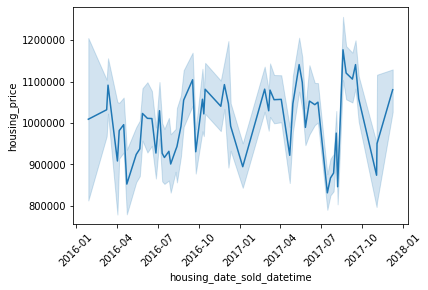

In [ ]:
seaborn.lineplot(data=melb_housing_df,
                 x="housing_date_sold_datetime",
                 y="housing_price")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=45)

No se observa una tendencia entre la fecha y el precio de venta. Las propiedades vendidas fluctuan entre los 800000 a 120000 con una alta variabilidad que se obtiene probablemente a que se están considerando no solo los años y meses, sino también el día de la venta, siendo esto quizás no tan relevante si se desea identificar un período donde se realizaron ventas de un alto valor.

(array([735964., 736055., 736146., 736238., 736330., 736420., 736511.,
        736603., 736695.]), <a list of 9 Text major ticklabel objects>)

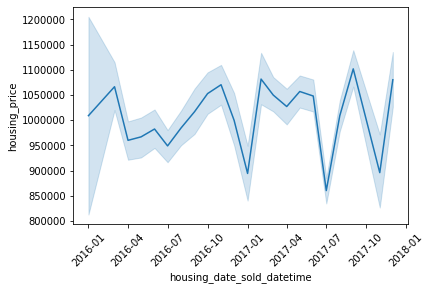

In [ ]:
melb_housing_df = melb_housing_df.assign(
    housing_date_sold_datetime= pd.to_datetime(melb_housing_df["housing_date_sold_datetime"].dt.strftime("%Y-%m")))

seaborn.lineplot(data=melb_housing_df,
                 x="housing_date_sold_datetime",
                 y="housing_price")
plt.ticklabel_format(style="plain", axis="y")
plt.xticks(rotation=45)

Si nos quedamos solamente con el mes y año de venta, se observa una menor variabilidad pero aún así no se perciben una tendencia clara en las fluctuaciones del precio.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text major ticklabel objects>)

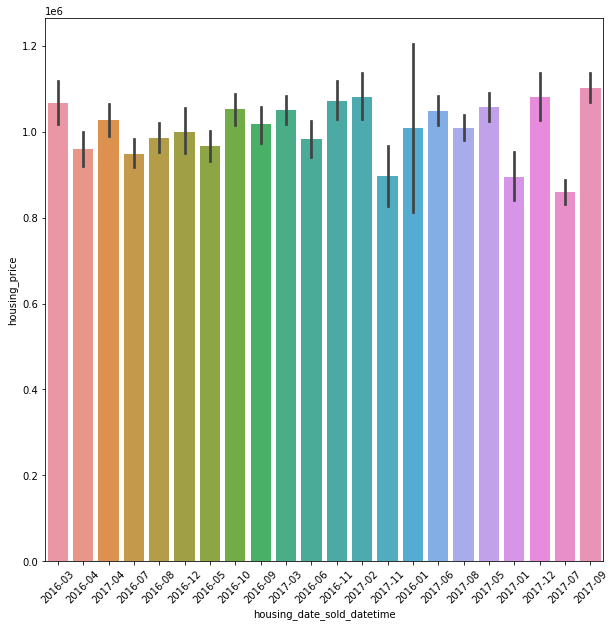

In [ ]:
melb_housing_df = melb_housing_df.assign(housing_date_sold_datetime=melb_housing_df["housing_date_sold_datetime"].dt.strftime("%Y-%m"))

plt.figure(figsize=(10, 10))
seaborn.barplot(data=melb_housing_df, x="housing_date_sold_datetime", y="housing_price", estimator=np.mean)
plt.xticks(rotation=45)

Se puede observar que los precios de venta en promedio son similares en los diferentes meses. Por lo tanto, se cree que debido al bajo rango de fechas que posee este dataset esta variable no sería significativa para estimar el precio de venta de las casas. 

### Año de construcción (`housing_year_built`)




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


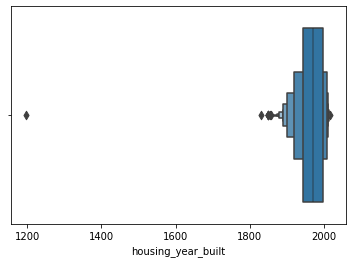

In [ ]:
seaborn.boxenplot(melb_housing_df["housing_year_built"])

Se observa que los años de construcción de las viviendas se distribuyen entre los años 1800 y 2010, con excepción de una sola propiedad construída en el año 1200. Dado que el objetivo es predecir el precio de venta de las viviendas, se consideró seleccionar el rango que abarca la mayor cantidad de ventas, eliminando el valor de vivienda construída en el 1200 por considerar que tiene una baja probabilidad de ocurrencia.

In [ ]:
melb_housing_df[melb_housing_df['housing_year_built']<1800]

,housing_address,housing_room_count,housing_type,housing_price,housing_selling_method,housing_seller_agency,housing_date_sold,housing_cbd_distance,housing_bedroom_count,housing_bathroom_count,housing_garage_count,housing_land_size,housing_building_area,housing_year_built,housing_lattitude,housing_longitude,suburb_id,housing_date_sold_datetime
9968,5 Armstrong St,3,h,1200000.0,VB,McGrath,24/06/2017,14.2,3.0,1.0,4.0,807.0,117.0,1196.0,-37.86788,145.12121,191,2017-06


In [ ]:
melb_housing_df=melb_housing_df[melb_housing_df['housing_year_built']>1800]
melb_housing_df['housing_year_built'].describe()

count    7966.000000
mean     1965.313332
std        35.844124
min      1830.000000
25%      1945.250000
50%      1970.000000
75%      1999.000000
max      2018.000000
Name: housing_year_built, dtype: float64

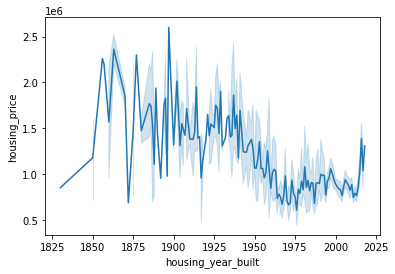

In [ ]:
seaborn.lineplot(data=melb_housing_df, x="housing_year_built", y='housing_price')

Se observa que las viviendas más antiguas tienen precios de venta más altos en comparación con las propiedades más nuevas. 
El año de construcción junto a la fecha de venta dan información acerca de la antiguedad de la propiedad. Debido a que las ventas fueron realizadas en un lapso corto de tiempo (2 años), se decidió seleccionar unicamente la variable `housing_year_built` ya que se podría obtener la misma información.

**Variables seleccionadas**

- `housing_price`
- cantidad de ambientes
- cantidad de baños
- tamaño del terreno
- building area
- tipo de vivienda
- región
- council area
- año de construcción 